In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython
import pyroomacoustics as pra
import pickle as pkl
import pandas as pd
from scipy.io import wavfile
from scipy.signal import fftconvolve
from scipy import signal
from matplotlib import gridspec

In [2]:
def compute_absorption(room_eadge,room_height,RT60):
    V = (room_eadge**2)*room_height
    S = 2*(room_eadge**2) + 4*(room_height**2)
    absr = 0.1611*(V/(S*RT60))
    return absr

In [3]:
folder_path = "/Users/youssef/Documents/EPFL/Semester_Project/Dataset/GDWN/WGN.wav"
file_to_open = folder_path 
ang = (np.array([61.]) / 180.) * np.pi
distance = 1.0
a = np.array([5.,5.,3.])
b = np.array([6.,6.,3.])
dimensions = np.stack((a,b))
distances = np.array([1.,2.])
RT60 = np.array([0.2,0.3])
absorption_1 = compute_absorption(a[0],a[2],RT60[0])
absorption_2 = compute_absorption(b[0],b[2],RT60[1])
absorptions = np.array([absorption_1,absorption_2])
print(absorptions.shape)
snr = 5.
fs,signal_wav = wavfile.read(file_to_open)
snrs = np.array([5,10,15,20])

(2,)


In [4]:
def generate_room_from_conditions(ang,distance,absorptions,snr,dimensions,typeofroom):
   
    room_dim = dimensions[typeofroom]
    room_eadge = room_dim[0]

    sf = (0.03*np.sqrt(2)/4)
    corners = np.array([[0,0],[0,room_eadge],[room_eadge,room_eadge],[room_eadge,0]]).T
    
    absr = absorptions[typeofroom]
    room = pra.Room.from_corners(corners, fs=fs , max_order=8 ,absorption=absorptions[typeofroom])
    #Understand the specifics of max_orders
    room.extrude(3.)

    # Add sources of 1 second duration
    #room_dim = np.array([5,5,3])
    rng = np.random.RandomState(23)
    duration_samples = int(fs)


    source_location = room_dim / 2 + (distance * np.array([np.cos(ang), np.sin(ang),0.0]))
    source_signal = rng.randn(duration_samples)
    room.add_source(source_location, signal = signal_wav)
    print('Here is the source at this step:',source_location) 

    #We initiate the point of the Tethra then we scale them
    #and translate the origin of the Tethra to the center of the room.
    R = np.array([(sf*np.array([1,1,-1,-1]))+2.5,(sf*np.array([1,-1,1,-1]))+2.5,(sf*np.array([1,-1,-1,1]))+1.5])# [[x], [y], [z]]
    room.add_microphone_array(pra.MicrophoneArray(R,room.fs))
    room.image_source_model(use_libroom=True)

    #Visualization
    fig, ax = room.plot(img_order=3)
    fig.set_size_inches(18.5,10.5)

    room.simulate(snr = snr)
    print('Here is the audio signal:',room.mic_array.signals[0][:5])
    return room.mic_array.signals,source_location,absr

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Here is the source at this step: [array([2.98480962]) array([3.37461971]) 1.5]
Here is the audio signal: [ 0.13070357 -0.11069063  0.40702485 -0.07076423 -0.13657484]
(49702,)


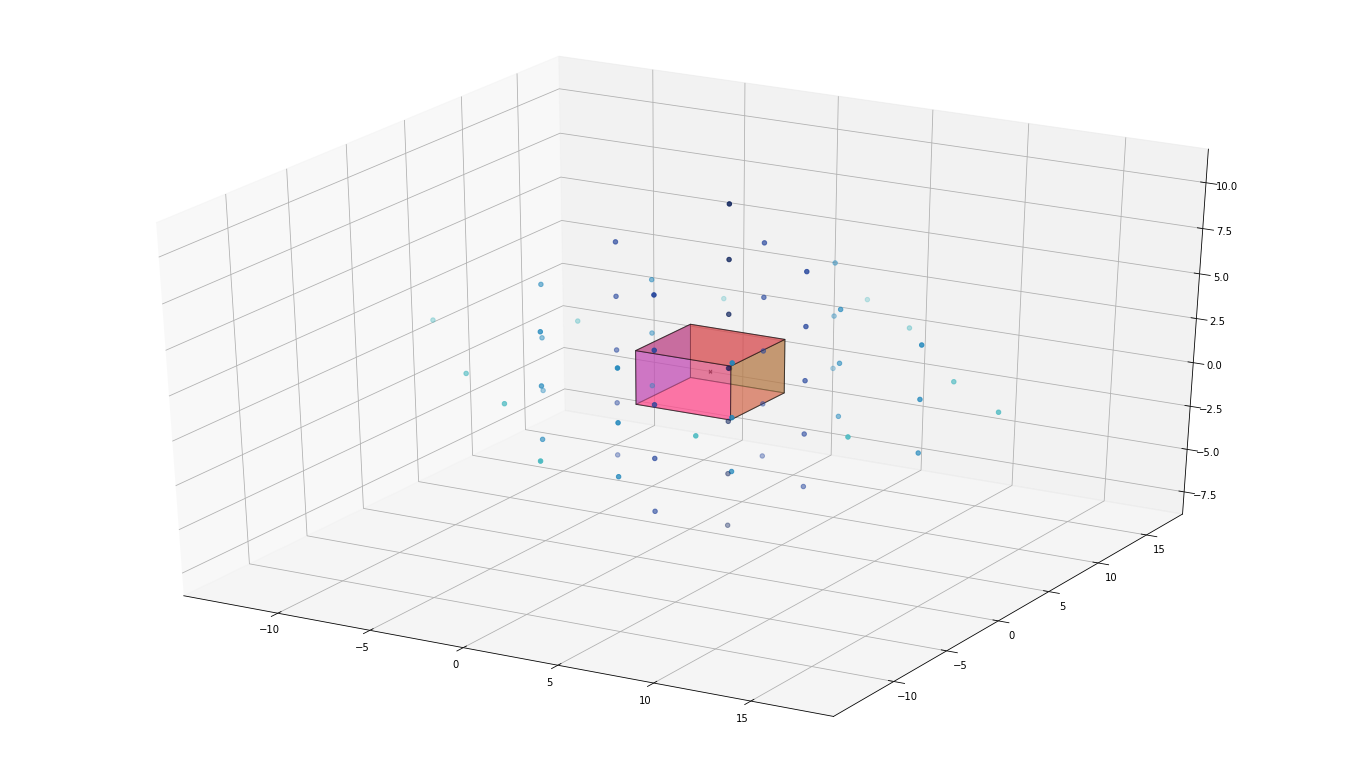

In [27]:

ang = (np.array([61.]) / 180.) * np.pi
audio_signals,source_loc,t = generate_room_from_conditions(ang,distances[0],absorptions,snr,dimensions,0)
print(audio_signals[0,:].shape)

In [69]:
def generate_phasematrix_from_signals(signals,j):
    
        path = "/Users/youssef/Documents/EPFL/DataSet/Training_Set/"   
        name_signals = 'audio_signals/audio_signals-{}'.format(j)
        fileName_audio = path + name_signals
        fileObject = open(fileName_audio, 'wb')
        pkl.dump(signals, fileObject)
        fileObject.close()                
    
        phase_matrix = np.empty((4, 129, 390))
        for i in range(4):
            f, t, stft_mic0 = signal.stft(audio_signals[i,:].astype(np.float32), fs)
            spectrum = stft_mic0
            magnitude = np.abs(spectrum)
            phase = np.angle(spectrum)
            #print('Here is the phase:',phase)
            x = phase.shape[0]
            y = phase.shape[1]
            print("HERE IS THE SHAPE",phase.shape)
            #phase_matrix = np.empty((4, x, y))
            phase_matrix[i] = phase
            
        path = "/Users/youssef/Documents/EPFL/DataSet/Training_Set/"   
        name_matrix = 'phase_matrix/Phase_matrix-{}'.format(j)
        fileName_matrix = path + name_matrix
        fileObject = open(fileName_matrix, 'wb')
        pkl.dump(phase_matrix, fileObject)
        fileObject.close()                    
        return fileName_audio,fileName_matrix

In [70]:
path_to_matrix = generate_phasematrix_from_signals(audio_signals,0)
print(path_to_matrix)

HERE IS THE SHAPE (129, 390)
HERE IS THE SHAPE (129, 390)
HERE IS THE SHAPE (129, 390)
HERE IS THE SHAPE (129, 390)
('/Users/youssef/Documents/EPFL/DataSet/Training_Set/audio_signals/audio_signals-0', '/Users/youssef/Documents/EPFL/DataSet/Training_Set/phase_matrix/Phase_matrix-0')


In [45]:
def assign_label_to_anlges(angles):
	bins = np.linspace(0, 180, 37)
	label = np.digitize(angles, bins)
	return label

In [58]:
def genere_dataset():
        index = 0
       
        df = pd.DataFrame(columns = ['Room','Array_position','Distance','Absorption','SNR','Audio_file','Phase_Matrix','label'])
	#We iterate of the type of rooms (R1,R2).
        for i in range (2):
            
	#We iterate of the distances from the microphones (1m,2m).	
            for j in range(2):
	#We iterate on the 7 random positions of the source.		
                for k in range(1):
                    print('Step:',index)
                    angles = np.random.uniform(low=0, high=180, size=(7,))
                    print('Here are the angles for this step:',angles) #Make the angles able to go to floats.
                    labels = assign_label_to_anlges(angles)
                    print('Here are the labels for this step:',labels) #Check if the labels match the angles.
                    azimuth = angles / 180. * np.pi 
                    snr = snrs[np.random.randint(4,size = 1)]
                    signals,array_position,absr = generate_room_from_conditions(azimuth[k],distances[j],absorptions,snr,dimensions,i)
                    fileName_audio,fileName_matrix = generate_phasematrix_from_signals(signals,index)
                    df = df.append({'Room':i,'Array_position':array_position,'Distance':distances[j],'Absorption':absr,'SNR':snr,'Audio_file':fileName_audio,'Phase_matrix':fileName_matrix,'Label':labels[k]} , ignore_index=True)
                    index = index+1
                    



'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Step: 0
Here are the angles for this step: [ 44.2648498   47.31894298  69.03878312 176.53400212 126.11358154
 152.49706127 125.84298485]
Here are the labels for this step: [ 9 10 14 36 26 31 26]
Here is the source at this step: [3.21612107 3.19797609 1.5       ]
Here is the audio signal: [-0.01981988  0.13219275  0.02752498 -0.11862643 -0.02065394]
HERE IS THE SHAPE (129, 390)
HERE IS THE SHAPE (129, 390)
HERE IS THE SHAPE (129, 390)
HERE IS THE SHAPE (129, 390)
Step: 1
Here are the angles for this step: [ 42.70113293  40.79294421  73.1026225   56.6814458   75.92205001
  61.78485093 123.66461852]
Here are the labels for this step: [ 9  9 15 12 16 13 25]
Here is the source at this step: [3.96980237 3.8563484  1.5       ]


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Here is the audio signal: [ 0.10987367 -0.20771572  0.02058822  0.06321832 -0.15090802]
HERE IS THE SHAPE (129, 390)
HERE IS THE SHAPE (129, 390)
HERE IS THE SHAPE (129, 390)
HERE IS THE SHAPE (129, 390)
Step: 2
Here are the angles for this step: [ 13.17274458 109.27336352 159.61537864 167.22935042 135.25714672
 152.65261808  35.10010961]
Here are the labels for this step: [ 3 22 32 34 28 31  8]
Here is the source at this step: [3.97368742 3.22788772 1.5       ]
Here is the audio signal: [ 0.22402127  0.31772268  0.17938055  0.04811854 -0.01616476]
HERE IS THE SHAPE (129, 390)
HERE IS THE SHAPE (129, 390)
HERE IS THE SHAPE (129, 390)
HERE IS THE SHAPE (129, 390)
Step: 3
Here are the angles for this step: [  0.96623829 151.20160257 146.58353617 109.84405822  92.38865974
 156.43131064 157.82709265]
Here are the labels for this step: [ 1 31 30 22 19 32 32]
Here is the source at this step: [4.99971561 3.03372648 1.5       ]


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Here is the audio signal: [ 0.33161087  0.5847174   0.18621868 -0.17157407  0.68755078]
HERE IS THE SHAPE (129, 390)
HERE IS THE SHAPE (129, 390)
HERE IS THE SHAPE (129, 390)
HERE IS THE SHAPE (129, 390)


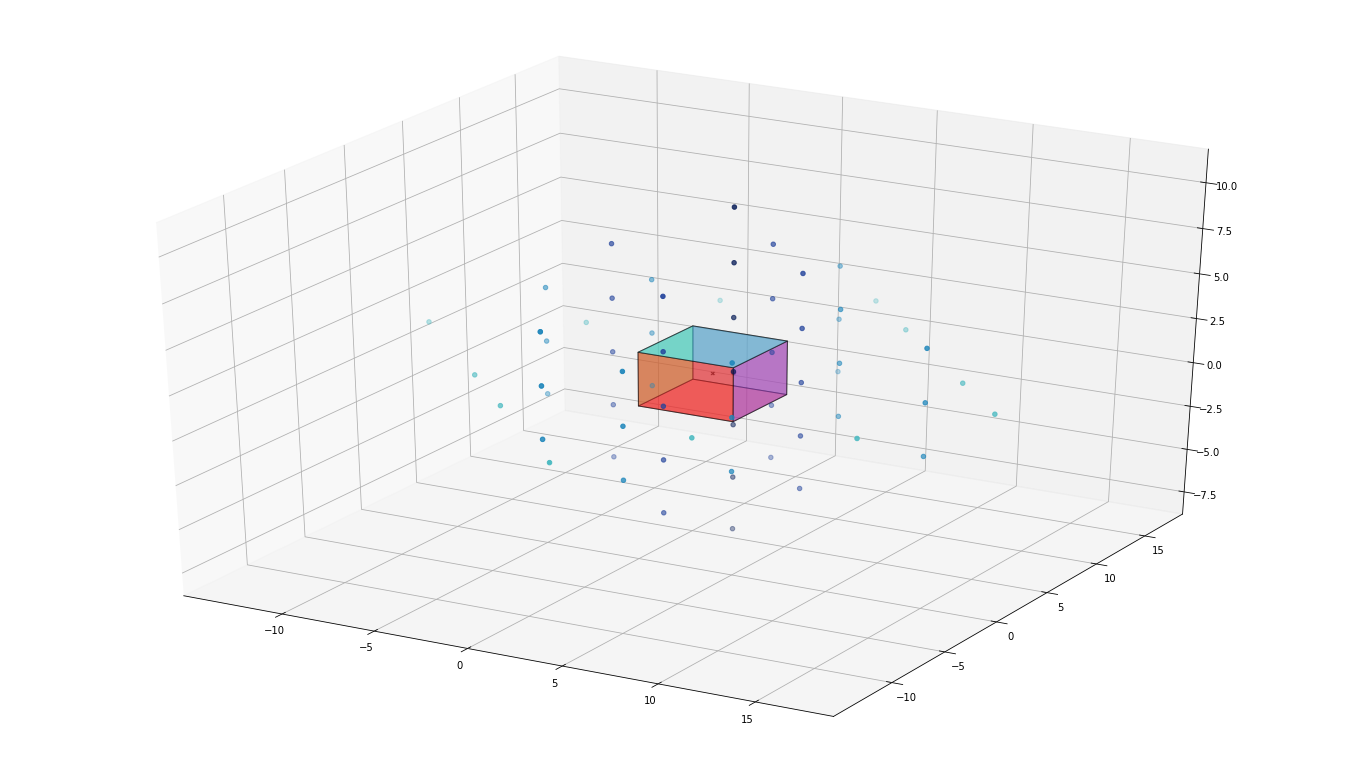

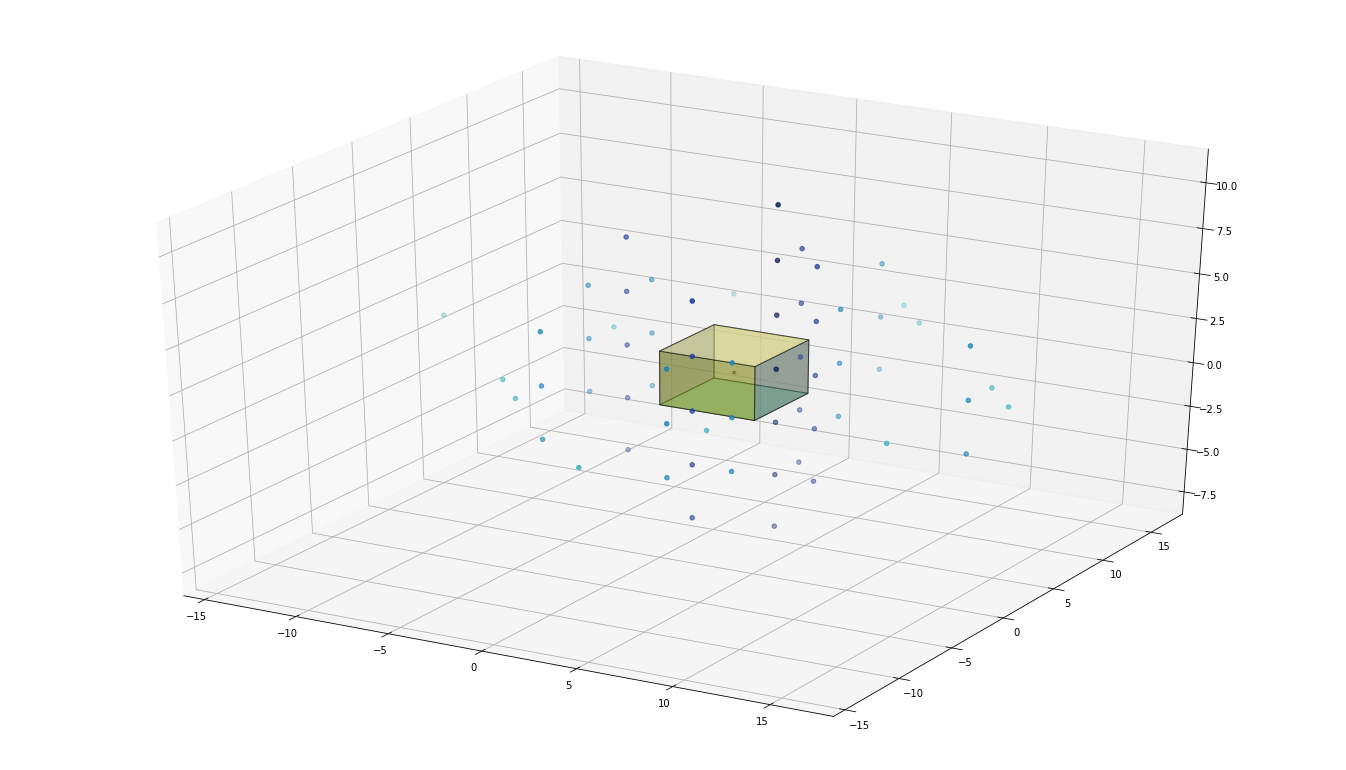

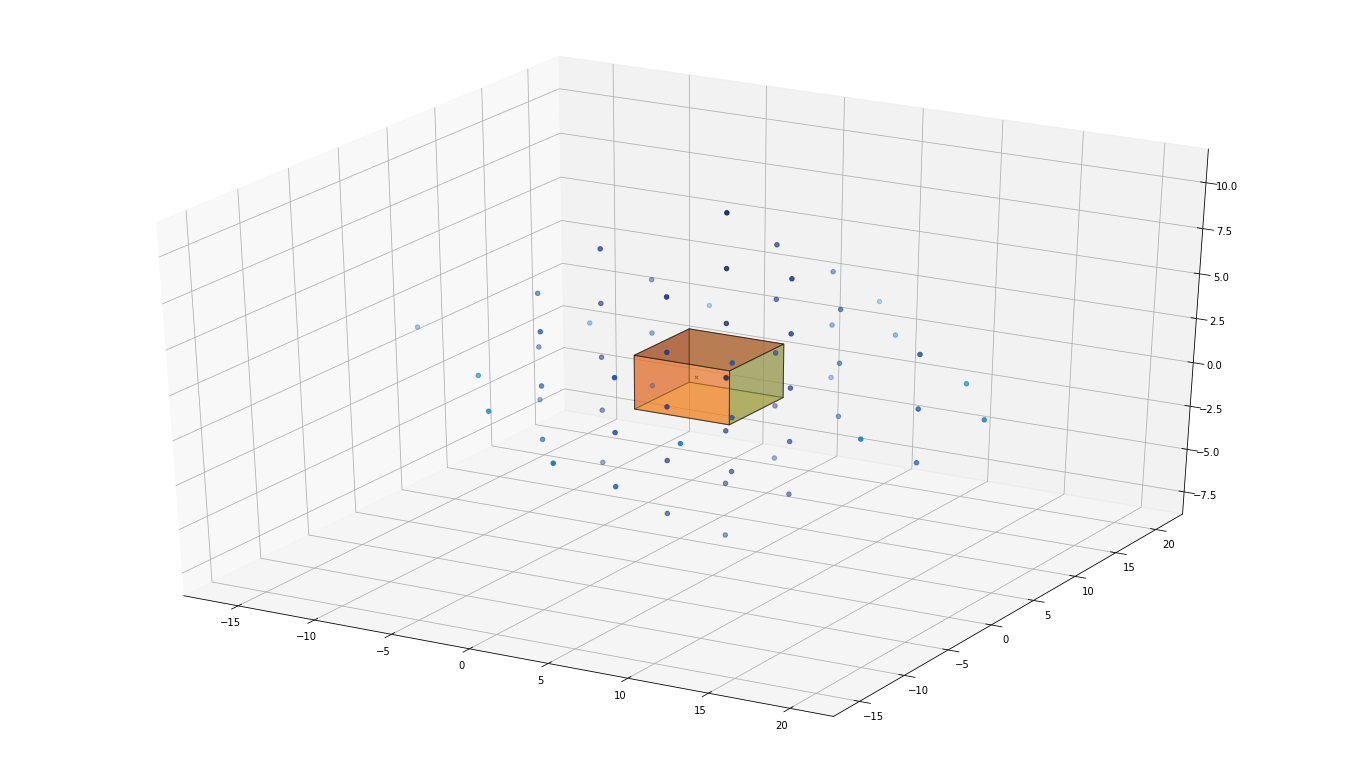

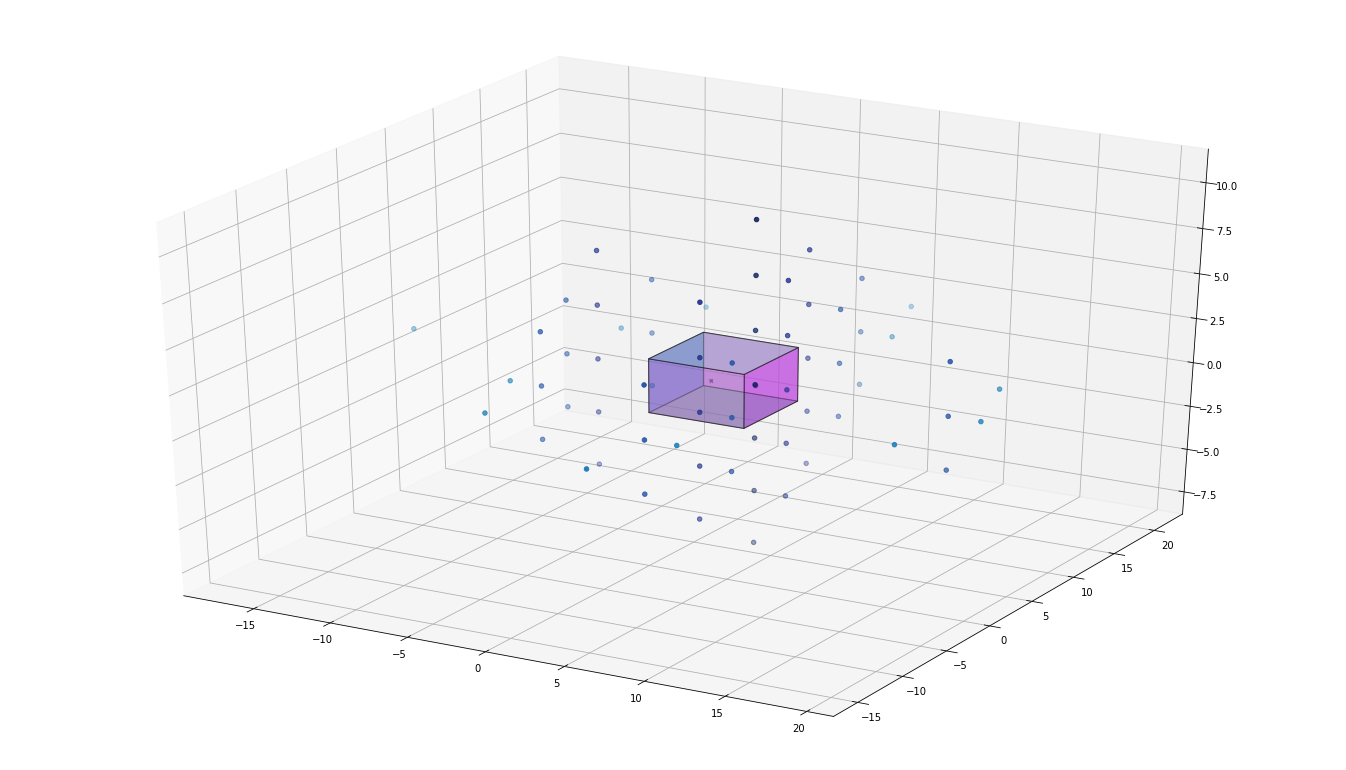

In [59]:
genere_dataset()

In [30]:
np.random.uniform(0,3,1)

array([2.18858964])

In [82]:
a = np.zeros((2,3))
size = a.shape[0]
size1 = a.shape[1]
b = np.zeros((3,size,size1))
b.shape

(3, 2, 3)